In [1]:
# imports
import os
os.sys.path.append(os.path.abspath(".."))

# import tensorflow as tf

# import random

# from copy import deepcopy

import pandas as pd
import numpy as np
import h5py

# import keras

from matplotlib import pyplot as plt

# import json

# import notebooks_utils.analysis as utils
from notebooks_utils import visuals

# from IPython.display import display

import project.download_content as content

# METAPATH = os.path.join(content.DATAPATH, 'METADATA')


# from keras.applications import VGG19, VGG16
from keras.preprocessing import image
# from keras.applications.vgg19 import preprocess_input as preprocess_19
# from keras.applications.vgg16 import preprocess_input as preprocess_16
# from keras.models import Model

# from keras import backend as K
# from keras import layers
from keras.optimizers import Adam, SGD

# import swifter

from project.model.ssd_model_300 import ssd_model_300
# from project.model.ssd_model_624 import ssd_model_624
from project.model.loss import SSDloss
# from project.model.iou import iou
# from project.model.smooth_l1 import smooth_l1

# from project.utils import data

Using TensorFlow backend.


## loading boat dataset

In [2]:
filepath = os.path.join(content.DATAPATH, "MODEL", "boats.h5")

boats = pd.read_hdf(filepath, 'X', mode='r')

with h5py.File(filepath, 'r') as f:
    target = f['y'][:]

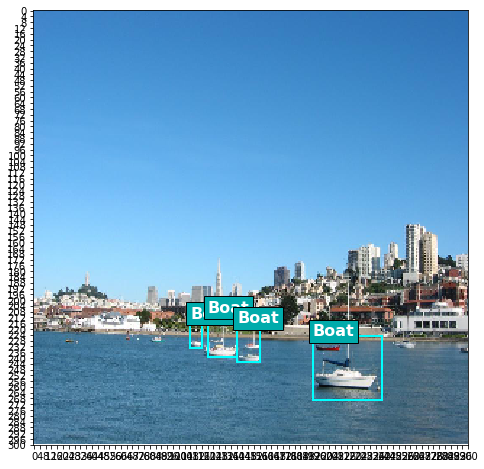

In [3]:
sample = boats.iloc[3223]

img = image.load_img(sample.Path, target_size=(300, 300))

plt.figure(figsize=(12,8))
plt.imshow(img)
# plt.grid()
plt.xticks(range(0, 301, int(300/75)))
plt.yticks(range(0, 301, int(300/75)))

visuals.draw_many_bboxes(img,
                         np.array([sample.cx, sample.cy, sample.w, sample.h]).T,
                         label='Boat');

## model

The model has 7 layers to draw the bounding_boxes, they were called as `number_bbs`

in each layer there are some types of bouding boxes, specified as follow:

|         | number of regions | size of filter in pixels | ratios w/h          | number of bounding boxes |
|---------|-------------------|--------------------------|---------------------|--------------------------|
| 1st_bbs | 5776              | 24px/24px                | [1, 1/2, 2]         | 17328                    |
| 2nd_bbs | 1369              | 48px/48px                | [1, 1/2, 2]         | 4107                     |
| 3rd_bbs | 289               | 98px/98px                | [1, 1/2, 1/3, 2, 3] | 1445                     |
| 4th_bbs | 49                | 208px/208px              | [1, 1/2, 1/3, 2, 3] | 245                      |
| 5th_bbs | 25                | 267px/267px              | [1, 1/2, 1/3, 2, 3] | 125                      |
| 6th_bbs | 9                 | 374px/374px              | [1, 1/2, 1/3, 2, 3] | 45                       |
| 7th_bbs | 1                 | 623px/624px              | [1, 1/2, 1/3, 2, 3] | 5                        |

In [18]:
model = ssd_model_300()

sgd = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
ssd_loss = SSDloss()
model.compile(optimizer=sgd, loss=ssd_loss.loss)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 300, 300, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 150, 150, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [5]:
y_true = target[12278]
y_true

array([[0.     , 1.     , 0.02374, 0.03168, 0.0475 , 0.06335],
       [1.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [1.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       ...,
       [1.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.     , 1.     , 0.4998 , 0.358  , 0.9995 , 0.3542 ],
       [1.     , 0.     , 0.     , 0.     , 0.     , 0.     ]],
      dtype=float16)

In [13]:
positives = tf.reduce_max(y_true[:, 1:-4], axis=-1)
a = tf.reduce_sum(positives)

if a == 3:
    print('boa')

boa


## Training

In [6]:
model.load_weights(content.DATAPATH + '/weights300.h5', by_name=True)

In [8]:
img_path = boats.iloc[421].Path
img = image.load_img(img_path, target_size=(300, 300))
X = image.img_to_array(img)

p = model.predict(np.expand_dims(X, axis=0))
p.shape

(1, 5770, 6)

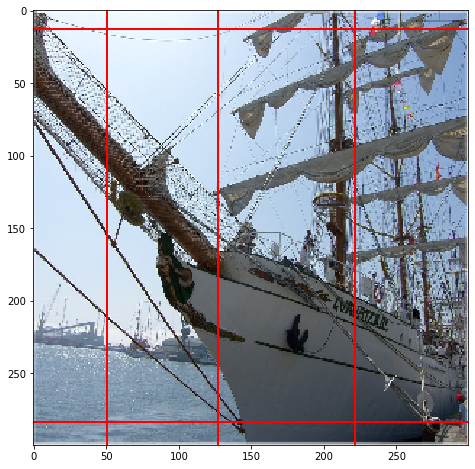

In [38]:
ps = p[0]

plt.figure(figsize=(12,8))
plt.imshow(img)

for x in ps:
    for i in x[2:]:
        if i>600:
            raise RuntimeError
    if x[1] > .99:
        visuals.draw_bbox(img, x[2:], color="#ff0000")